# Simple Case Impacts on Linear Regression Fit and Prediction

In [162]:
from generator import *
from shredder import *
from fitter import *
from fixer import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
np.random.seed(10)


# Generating regression data -- Background
`x_def_helper` helps define a single random variables as required.  It accepts the name of the desired distribution, the coefficient value, and the keyword arguments that define the distribution according to the Numpy random generators.

`generate_ind_model` creates a `p` regressor linear regression set as specified in the `dist_types` argument, a list of `dicts` generated by `x_def_helper`. The user must also specify the intercept, noise_factor, and number of observations.  This will return a tuple of two dataframes, one is (`n`, `p`), the other, a test set, is (`.5*n`, `p`).


## Case 1: Single Uniformly Distributed Regressor -- Generate the data

In [163]:
# Declare that there should be one X uniformly distributed between 0 and 100 with a coefficient of 5.

dist_types = [
#     x_def_helper('lognormal', coeff=10, mean=0, sigma=1),
    x_def_helper('uniform', coeff=6, low=0, high=100)
]

x1_uniform_clean_fit_data, x1_uniform_test_data = generate_ind_model(1, dist_types, intercept=10, n=200, noise_factor=.1)

print("The shape of the data set and the test set")
print(x1_uniform_clean_fit_data.shape, x1_uniform_test_data.shape)

The shape of the data set and the test set
(200, 2) (100, 2)


In [164]:
x1_uniform_clean_fit_data.head()

,x1,y
0,77.132064,416.440410
1,2.075195,57.203265
2,63.364823,394.254979
3,74.880388,542.732679
4,49.850701,268.550153


### Initial EDA/Modeling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c79fd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1193572e8>]], dtype=object)

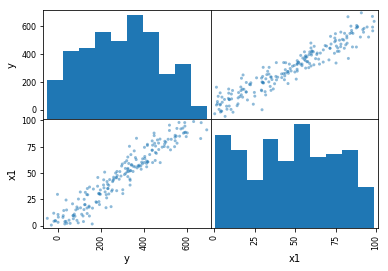

In [165]:
scatter_matrix(x1_uniform_clean_fit_data[['y', 'x1']])

### Building and checking a model fit to the unaltered data

In [166]:
ex_fitted, ex_metrics, = fit_lm(x1_uniform_clean_fit_data, x1_uniform_test_data)
print(ex_fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     1893.
Date:                Mon, 29 Jan 2018   Prob (F-statistic):          2.73e-103
Time:                        13:07:00   Log-Likelihood:                -1081.7
No. Observations:                 200   AIC:                             2167.
Df Residuals:                     198   BIC:                             2174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7035      7.634      1.140      0.2

Text(0.5,15,'x1')

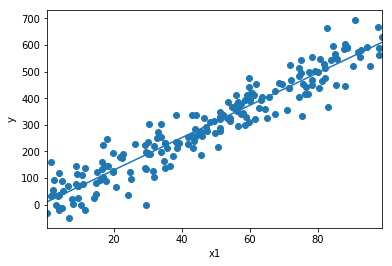

In [167]:
fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(x1_uniform_clean_fit_data['x1'], x1_uniform_clean_fit_data['y'])
plt.ylabel('y')
plt.xlabel('x1')


47.205441448840865


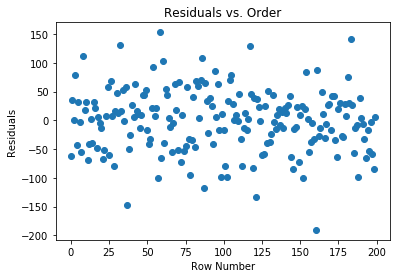

In [168]:
plt.plot(ex_fitted.resid, marker='o', linestyle='')
plt.title('Residuals vs. Order')
plt.ylabel('Residuals')
plt.xlabel('Row Number')

# fig, ax = plt.subplots(figsize=(12,8))
# fig = sm.graphics.influence_plot(ex_fitted, ax=ax, criterion="cooks")
print(x1_uniform_clean_fit_data['x1'].mean())

34.6153688116


2630.9909479986322

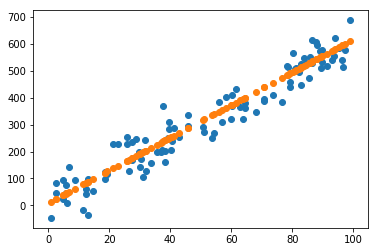

In [169]:
test_X = x1_uniform_test_data.loc[:, x1_uniform_test_data.columns != "y"]
test_X = sm.add_constant(test_X)
test_y = x1_uniform_test_data.loc[:, 'y']
y_pred = ex_fitted.predict(test_X)


fig, ax = plt.subplots()
ax.scatter(test_X['x1'], test_y)
ax.scatter(test_X['x1'], y_pred)

print(mean_absolute_percentage_error(test_y, y_pred))
mean_squared_error(test_y, y_pred)


## Case 1: Wrecking and Fitting the Data
### Data Shredder
The shredder has been written into it's own function to make the code below more readable.  Here is the source code and how it works:
```python
def uniform_shred_cols(cols, pct_trash, df):
    df.loc[
        np.random.choice(
            np.arange(0, df.shape[0]), 
            int(pct_trash*df.shape[0]), 
            replace=False), 
        cols] = np.NaN
    return df
```
1. Choose `n` random index positions from `0` to `n_obs` without replacement
2. Set the specified columns in the randomly selected rows to NULL


### Fit, Shred, Repeat Loop
The general prodecure is as following:

`Open the loop that replicates 0 - 100% data destruction experiment M times. `

`Open loop iterating the percent of data to be destroyed.`

1. Copy the source data to avoid memory mistakes
2. Wipe out the correct percent of data for this iteration.
3. Either drop or impute the missing data. 
4. Fit model with the resulting data
5. Add the results of this run to the results dataframe

### Metrics Collected
For all models fit, the following metrics are computed and collected for later inspection.
- R-Squared
- R-Squared Adjusted
- R-Squared Predicted (using the test set)
- MSE Predicted
- [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)
- Range of the CI of the Beta for x1

### Case 1 - Part 1: Randomly Removing Values of `x1` and Dropping Respective Rows 

In [170]:
wreck_results = []
# Begin replication loop
for i in range(50):
    
    # Begin percent range loop
    for pct in np.arange(0, 1, .025):
    
        # Make a copy of the dataset so that we do not contaminate the memory
        wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)

        # Shred the data unless pct == 0
        if pct != 0:
            # Specify that we are shredding x1
            uniform_shred_cols(['x1'], pct, wrecked_data)
            wrecked_data = wrecked_data.dropna()

        w_fitted, w_metrics, = fit_lm(wrecked_data, x1_uniform_test_data)

        wreck_results.append((pct,
                              w_fitted.nobs,
                              w_metrics['r2'],
                              w_metrics['r2_adj'],
                              w_metrics['bic'],
                              w_metrics['beta_ci']['x1']['range'],
                              w_metrics['beta_ci']['x1']['low'],
                              w_metrics['beta_ci']['x1']['high'],
                              w_metrics['r2_pred'],
                              w_metrics['mse_pred']))


# Load the results into a Pandas Dataframe
results_df = pd.DataFrame(wreck_results, columns=['pct_missing', 
                                                  'nobs', 
                                                  'r2', 
                                                  'r2_adj',
                                                  'bic', 
                                                  'beta_x1_rng', 
                                                  'beta_x1_low',
                                                  'beta_x1_high',
                                                  'r2_pred', 
                                                  'mse'])


In [171]:
# Processing results
x1_uniform_results = results_df.groupby('pct_missing').mean()
x1_uniform_results

,nobs,r2,r2_adj,bic,beta_x1_rng,beta_x1_low,beta_x1_high,r2_pred,mse
pct_missing,,,,,,,,,
0.000,200.0,0.905292,0.904814,2173.969420,0.551250,5.804918,6.356168,0.923170,2630.990948
0.025,195.0,0.905528,0.905038,2119.520387,0.557664,5.802070,6.359734,0.923119,2632.721600
0.050,190.0,0.905319,0.904816,2065.424104,0.565450,5.794552,6.360003,0.923254,2628.086461
0.075,185.0,0.904987,0.904468,2012.280563,0.574654,5.793303,6.367957,0.923154,2631.530394
0.100,180.0,0.904961,0.904427,1956.728442,0.581872,5.779758,6.361630,0.923062,2634.658446
0.125,175.0,0.905218,0.904670,1902.846450,0.590418,5.786091,6.376509,0.922941,2638.805716
0.150,170.0,0.905327,0.904764,1850.064871,0.599621,5.790289,6.389910,0.922979,2637.530285
0.175,165.0,0.903890,0.903301,1794.771206,0.610281,5.747741,6.358022,0.923226,2629.067565
0.200,160.0,0.904790,0.904188,1741.081366,0.619476,5.769960,6.389437,0.922923,2639.444084


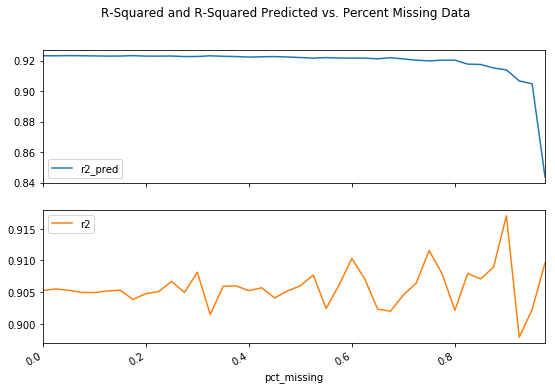

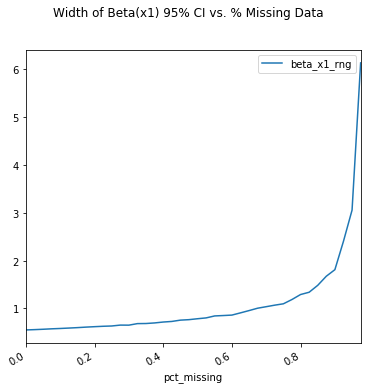

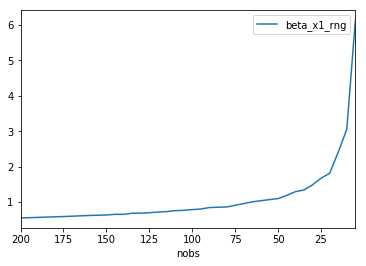

In [172]:
x1_uniform_results[['r2_pred', 'r2']].plot(subplots=True, figsize=(9, 6), title='R-Squared and R-Squared Predicted vs. Percent Missing Data')
print()

x1_uniform_results[['beta_x1_rng']].plot(subplots=True, figsize=(6, 6), title='Width of Beta(x1) 95% CI vs. % Missing Data')

x1_uniform_results.plot(y='beta_x1_rng', x='nobs')
#init_results[['beta_x1_low', 'beta_x1_high']].plot(figsize=(9, 9))
                                       
#init_results['log_beta_x1_rng'] = np.log(init_results[['beta_x1_rng']])
#init_results[['log_beta_x1_rng']].plot(subplots=True, figsize=(9, 9))

### Case 1 - Part 1: Discussion
In part 1, the impacts of the missing data on fit and parameter estimation can be explained simply by the impact of an increasingly limited number of observation on the ability of an OLS model to fit the data. The data used in Case 1 only consists of one variable explaining one response. With a simple relationship, only a small number of observations is required to achieve a satisfactory fit. In other words, the quality of fit is not dramatically different between a model with 100 samples and a model with 60. While interesting to observe this phenomenon, it is well known that modeling with a larger number of observations yields better results.  

If so inclined, one could rerun the above experiment starting with a dataset of 1000 samples and set the percent increment from .05 to .0125 for higher resolution.  This confirms that the ability of the model gets significantly worse only when the number of falls below ~40. 




## Case 1 - Part 2:  Randomly Removing Values of `x1` and Filling with Mean of `x1`
### Imputing with the a descriptive statistic of `x1` (mean in this example)
1) Start with the original data

2) Shred it, setting `x1` to NULL on some portion of the rows which yields a dataframe shown below. 

3) The mean of the remaining `x1` is computed and used to fill in the NULL `x1` values.

In [154]:
wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)
wrecked_data = uniform_shred_cols(['x1'], .4, wrecked_data)

wrecked_data.head(n=10)


,x1,y
0,16.575862,130.240348
1,79.754887,537.854558
2,50.266661,388.372744
3,29.510298,238.863568
4,NaN,152.616647
5,NaN,305.473669
6,NaN,188.198512
7,NaN,518.879597
8,12.469104,162.207368
9,NaN,252.690732


In [155]:
print("The mean of x1 is: %1.4f" % wrecked_data['x1'].mean())

The mean of x1 is: 51.9971


4) Now we want to assign all the NULL values to the mean of the non-NULL x1 data.  Notice that the rows that were NaN above are now set to the mean.

In [156]:
fixed_data = wrecked_data.fillna(value={'x1': wrecked_data['x1'].mean()})
fixed_data.head(n=10)

,x1,y
0,16.575862,130.240348
1,79.754887,537.854558
2,50.266661,388.372744
3,29.510298,238.863568
4,51.997081,152.616647
5,51.997081,305.473669
6,51.997081,188.198512
7,51.997081,518.879597
8,12.469104,162.207368
9,51.997081,252.690732


To make this process both easier to read and scaleable, a wrapper was written to allow simply repair to any of the `x` variables in the dataframe. It accepts a `dict` with `regressor:descriptive stat` pairs. These are translated to the correct function calls. A repaired dataframe is returned.

```python
fix_cols({'x1': 'mean'}, wrecked_data)
```

In [157]:
p2_wreck_results = []
# Begin replication loop
for i in range(50):
    
    # Begin percent range loop
    for pct in np.arange(0, 1, .025):    
        # Make a copy of the dataset so that we do not contaminate the main memory copy
        wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)

        # Shred the data unless pct == 0
        if pct != 0:
            # Specify that we are
            uniform_shred_cols(['x1'], pct, wrecked_data)
            fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
        else: 
            fixed_data = wrecked_data

        w_fitted, w_metrics, = fit_lm(fixed_data, x1_uniform_test_data)

        p2_wreck_results.append((pct,
                              w_fitted.nobs,
                              w_metrics['r2'],
                              w_metrics['r2_adj'],
                              w_metrics['bic'],
                              w_metrics['beta_ci']['x1']['range'],
                              w_metrics['beta_ci']['x1']['low'],
                              w_metrics['beta_ci']['x1']['high'],
                              w_metrics['r2_pred'],
                              w_metrics['mse_pred']))


# Load the results into a Pandas Dataframe
p2_results_df = pd.DataFrame(p2_wreck_results, columns=['pct_missing', 
                                                  'nobs', 
                                                  'r2', 
                                                  'r2_adj',
                                                  'bic', 
                                                  'beta_x1_rng', 
                                                  'beta_x1_low',
                                                  'beta_x1_high',
                                                  'r2_pred', 
                                                  'mse'])


In [158]:
x1_uniform_p2_results = p2_results_df.groupby('pct_missing').mean()
x1_uniform_p2_results

,nobs,r2,r2_adj,bic,beta_x1_rng,beta_x1_low,beta_x1_high,r2_pred,mse
pct_missing,,,,,,,,,
0.000,200.0,0.885773,0.885196,2206.181974,0.603244,5.691629,6.294873,0.866230,4083.353424
0.025,200.0,0.861804,0.861106,2243.572651,0.672183,5.656462,6.328645,0.866086,4087.767564
0.050,200.0,0.845384,0.844603,2265.388112,0.718261,5.639445,6.357706,0.866011,4090.031795
0.075,200.0,0.819926,0.819017,2295.625721,0.785868,5.596341,6.382209,0.865841,4095.226379
0.100,200.0,0.791728,0.790676,2325.053991,0.859182,5.551234,6.410416,0.865855,4094.814241
0.125,200.0,0.781369,0.780265,2334.535785,0.889337,5.558028,6.447365,0.865419,4108.119643
0.150,200.0,0.751648,0.750393,2360.470917,0.966373,5.516234,6.482608,0.865523,4104.931332
0.175,200.0,0.729745,0.728380,2377.004633,1.021694,5.481281,6.502974,0.865317,4111.232139
0.200,200.0,0.703393,0.701895,2396.079105,1.090842,5.448374,6.539216,0.865125,4117.085427


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11c6c8f60>], dtype=object)

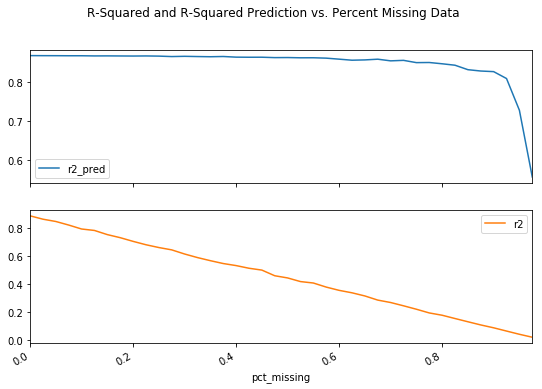

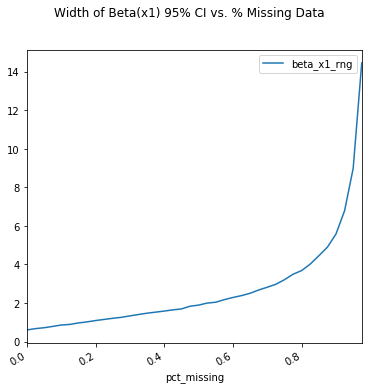

In [159]:
x1_uniform_p2_results[['r2_pred', 'r2']].plot(subplots=True, figsize=(9, 6), title='R-Squared and R-Squared Prediction vs. Percent Missing Data')
print()

x1_uniform_p2_results[['beta_x1_rng']].plot(subplots=True, figsize=(6, 6), title='Width of Beta(x1) 95% CI vs. % Missing Data')


### Case 1 - Part 2: Discussion
Okay, before diving in, let's look at what's happening in the model when we impute some data to the mean. 

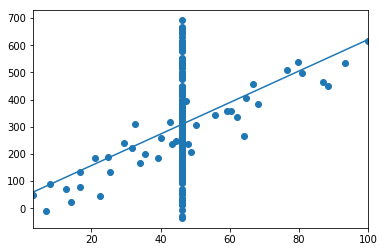

In [160]:
wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)
wrecked_data = uniform_shred_cols(['x1'], .8, wrecked_data)

fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
ex_fitted, ex_metrics, = fit_lm(fixed_data, x1_uniform_test_data)


fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(fixed_data['x1'], fixed_data['y'])

### Case 1 Comparison of Drop vs. Impute
To understand which of these two methods produces a superior model the various fit and prediction metrics are plotted side by side for each method. 


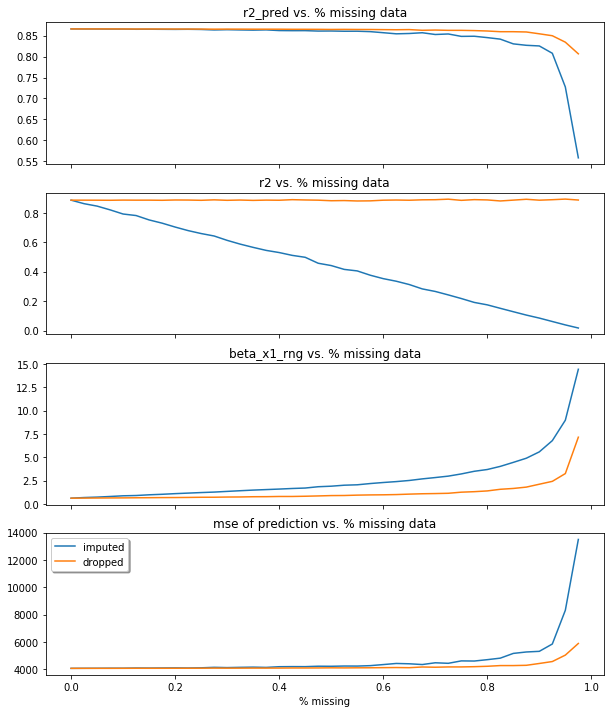

In [161]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(4, sharex=True, figsize=(10,12))

axarr[0].plot(x1_uniform_p2_results[['r2_pred']], label='imputed')
axarr[0].plot(x1_uniform_results[['r2_pred']], label='dropped')
axarr[0].set_title('r2_pred vs. % missing data')

axarr[1].plot(x1_uniform_p2_results[['r2']], label='imputed')
axarr[1].plot(x1_uniform_results[['r2']], label='dropped')
axarr[1].set_title('r2 vs. % missing data')

axarr[2].plot(x1_uniform_p2_results[['beta_x1_rng']], label='imputed')
axarr[2].plot(x1_uniform_results[['beta_x1_rng']], label='dropped')
axarr[2].set_title('beta_x1_rng vs. % missing data')

axarr[3].plot(x1_uniform_p2_results[['mse']], label='imputed')
axarr[3].plot(x1_uniform_results[['mse']], label='dropped')
axarr[3].set_title('mse of prediction vs. % missing data')


axarr[3].set_xlabel('% missing')
plt.legend(shadow=True, fancybox=True)